In [1]:
import os
import sys
sys.path.append('../../kl_tools/')
import numpy as np
from astropy.units import Unit
import matplotlib.pyplot as plt
import galsim as gs
import galsim.roman as roman

import basis
import cube
import intensity
import likelihood
import mcmc
import parameters
from parameters import Pars
import priors
import utils
import velocity
from DataSimulator import DataSimulator

# new modules
from spectrum import Spectrum
#from MockObs import Mock
%matplotlib inline

In [17]:
pars_total = {
    # priors of sampled parameters
    'priors':{
        'g1': priors.GaussPrior(0., 0.1),
        'g2': priors.GaussPrior(0., 0.1),
        'theta_int': priors.UniformPrior(-np.pi/2., np.pi/2.),
        'sini': priors.UniformPrior(0., 1.),
        'v0': priors.GaussPrior(0, 20),
        'vcirc': priors.GaussPrior(200, 10),
        'rscale': priors.UniformPrior(0, 10),
    },
    # dimension parameters for model cube
    # Note that the dimensions and scales in this parameter are irrelevant
    # to the pixel scale and number of pixels in the observed image. The 
    # model cube object is by design independent of the configurations of
    # observations. A parametric surface brightness profile is drawn on 
    # this meta-grid, then observed data will be interpolated from that. 
    'model_dimension':{
        'Nx':64,
        'Ny':64,
        'scale':0.1,# arcsec
        'lambda_range':[1200, 1400],
        'lambda_res': 1,# nm
        'lambda_unit': 'nm'
    },
    # intensity profile, or surface brightness model for the galaxy
    'intensity':{
        'type':'inclined_exp',
        'hlr':0.5,# arcsec
    },
    # kinematics model for the galaxy
    'velocity':{
        'model_name': 'default',
        'v_unit':Unit('km / s'),
        'r_unit':Unit('arcsec'),
    },
    # SED model for the galaxy
    'sed':{
        'template':'../../data/Simulation/GSB2.spec',
        'wave_type': 'Ang',
        'flux_type': 'flambda',
        'z': 1.0,
        'wave_range': (500, 3000), # nm
        # obs-frame continuum normalization (nm, erg/s/cm2/nm)
        'obs_cont_norm': (400, 1e-16),
        # a dict of line names and obs-frame flux values (erg/s/cm2)
        'lines': {'Halpha': 1e-15, 'OII':[1e-15, 1.2e-15], 'OIII':[1e-15, 1.2e-15]},
        # intrinsic linewidth in nm
        'line_sigma_int': {'Halpha': 4, 'OII':[2,2], 'OIII':[3,3]},
    },
    # observation related parameters
    # Note that from the same galaxy and shear model, we can derive 
    # multiple types of data,
    # e.g. `photometry`, `slit_spectroscopy`, `grism` and/or `IFU`.
    # Thus 'observations' is a list of dictionaries that specify 
    # observation-wise parameters.
    # TODO: maybe think about more flexible way to describe dispersion
    'observations': {
        'number_of_observations': 3,
        'obs_3': {# Roman WFI/GRISM observation, roll angle 1
            'inst_name':'Roman/WFI',
             'type':'grism',
             'bandpass':'../../data/Bandpass/Roman/WFI_Grism_1stOrder.dat',
             'Nx': 64,# number of pixels
             'Ny': 64,
             'pixel_scale': 0.11,# arcsec
             'R_spec':461,# at 1 micron
             # can be 'airy'/'moffat'/'kolmogorov'/'vonkarman'/'opticalpsf'
             'psf_type':'airy',
             # pass the needed params to build PSF model here
             # in case of airy, we don't need any params
             'psf_kwargs':{'fwhm':0.13},# arcsec
             'disp_ang':0.,# radian
             'offset': -1210,# pix
             'diameter':240,# cm
             'exp_time':300.,# seconds
             'gain':1.,
             'noise':{'type':'ccd','sky_level':0.65*1.2,'read_noise':8.5}
         },
        'obs_2': {# Roman WFI/GRISM observation, roll angle 2
            'inst_name':'Roman/WFI',
             'type':'grism',
             'bandpass':'../../data/Bandpass/Roman/WFI_Grism_1stOrder.dat',
             'Nx': 64,# number of pixels
             'Ny': 64,
             'pixel_scale': 0.11,# arcsec
             'R_spec':461,# at 1 micron
             'psf_type':'airy',
             'psf_kwargs':{'fwhm':0.13},# arcsec
             'disp_ang':np.pi/2.,# radian
             'offset': -1210,#pix
             'diameter':240,# cm
             'exp_time':300.,# seconds
             'gain':1.,
             'noise':{'type':'ccd','sky_level':0.65*1.2,'read_noise':8.5}
         },
        'obs_1': {# Roman WFI/Photometry image observation, H band
            'inst_name':'Roman/WFI',
             'type':'photometry',
             'bandpass':'../../data/Bandpass/Roman/WFI_F129.dat',
             'Nx': 32,# number of pixels
             'Ny': 32,
             'pixel_scale': 0.11,# arcsec
             'psf_type':'airy',
             'psf_kwargs':{'fwhm':0.13},# arcsec
             'diameter':240,# cm
             'exp_time':300.,# seconds
             'gain':1.,
             'noise':{'type':'ccd','sky_level':0.65*1.2,'read_noise':8.5},
         },
    },
    
    'use_numba': False,
}
sp = ['g1', 'g2', 'theta_int', 'sini', 'v0', 'vcirc', 'rscale']
sp_val = [0.0, 0.0, 0.0, 0.5, 0.0, 200.0, 0.5]

test_Pars = Pars(sp, pars_total)

In [18]:
test_Pars.theta2pars(sp_val)

{'g1': 0.0,
 'g2': 0.0,
 'theta_int': 0.0,
 'sini': 0.5,
 'v0': 0.0,
 'vcirc': 200.0,
 'rscale': 0.5}

# Testing `DataSimulator` Class

In [19]:
ds = DataSimulator(test_Pars)


[ImageGenerator] Init:
--- Instrument name = Roman/WFI
--- Aperture diameter = 240.00 cm
--- Aperture area = 45238.93 cm2
--- Detector gain = 1.00
--- Exposure time = 300.00 seconds
--- Noise type = ccd
--- PSF type = airy
--- Bandpass file = ../../data/Bandpass/Roman/WFI_F129.dat
--- Theory slice dimension = (64, 64)
--- Theory slice scale = 0.10
--- Observed slice dimension = (32, 32)
--- Observed slice pixel scale = 0.11

[GrismGenerator] Init:
--- Instrument name = Roman/WFI
--- Aperture diameter = 240.00 cm
--- Aperture area = 45238.93 cm2
--- Detector gain = 1.00
--- Exposure time = 300.00 seconds
--- Noise type = ccd
--- PSF type = airy
--- Bandpass file = ../../data/Bandpass/Roman/WFI_Grism_1stOrder.dat
--- Theory slice dimension = (64, 64)
--- Theory slice scale = 0.10
--- Observed slice dimension = (64, 64)
--- Observed slice pixel scale = 0.11
--- Dispersion angle = 90.00 deg
--- Spectral resolution at 1um = 461.00
--- Grism offset = -1210 pixels

[GrismGenerator] Init:
---

In [20]:
%time datavectors, covmats = ds.evaluateSimulatedData(sp_val)

CPU times: user 955 ms, sys: 10.2 ms, total: 965 ms
Wall time: 963 ms


In [21]:
print(ds.imap)

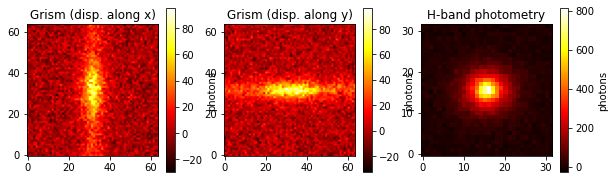

In [22]:
fig, axes = plt.subplots(1,3, figsize=(10,3))
cmap = 'hot'

cb1 = axes[0].imshow(datavectors[1], origin='lower', cmap=cmap)
axes[0].set_title("Grism (disp. along x)")
plt.colorbar(cb1, ax=axes[0], label='photons')

cb2 = axes[1].imshow(datavectors[2], origin='lower', cmap=cmap)
axes[1].set_title("Grism (disp. along y)")
plt.colorbar(cb2, ax=axes[1], label='photons')

cb3 = axes[2].imshow(datavectors[0], origin='lower', cmap=cmap)
axes[2].set_title("H-band photometry")
plt.colorbar(cb3, ax=axes[2], label='photons')

plt.show()

# Testing `GrismGenerator` Class

In [ ]:

Nobs = len(pars_total['observations'])
print("{} observations".format(Nobs))
pars_obs = pars_total['observations'].copy()
pars = []
for i in range(Nobs):
    _p = pars_total.copy()
    _p['observations'] = pars_obs[i]
    pars.append(_p)
p = parameters.Pars(sp, pars[1])
simulator1 = cube.GrismGenerator(p)

In [ ]:
import random
from time import time
import galsim as gs

gs.BaseDeviate( int(time()) )

In [ ]:
a = [1,2,3,4,5]
b = np.array([1,2,3,4,5,6,7])
if isinstance(a, (list, np.ndarray)):
    print("Y")

In [ ]:
dict_a = {
    'intensity': 'inc',
    'observations':{
        'num': 3,
        'obs_1': {
            'a': 1,
            'b': 2,
            'c': 3,
        },
        'obs_2': {
            'a': 4,
            'b': 5,
            'c': 6,
        },
        'obs_3': {
            'a': 7,
            'b': 8,
            'c': 9,
        },
    },
}

In [ ]:
print(dict_a.keys())
dict_obs = dict_a.pop('observations')
print(dict_a.keys())
print(dict_obs.keys())
for i in range(dict_obs['num']):
    print(dict_obs['obs_%d'%(i+1)])

In [ ]:
gal = gs.InclinedExponential(gs.angle.Angle(np.pi/4, gs.angle.radians), scale_radius = 1)
isinstance(gal, gs.GSObject)

In [ ]:
spec = gs.SED()